# Securities portfolio modeling. Allocation, optimization and analysis
### Kirill Zakharov
#### telegram: @kirillzx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as sts
import yfinance as yf
from scipy.optimize import linprog
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import datetime
plt.style.use('ggplot')
from fbprophet import Prophet
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
class Portfolio:
    def __init__(self, names, dates):
        self.n = len(names)
        self.names = names
        self.data = pd.DataFrame()
        self.new_data = pd.DataFrame()
        self.w = np.array([1/self.n]*self.n)
        self.month_return = 0
        self.month_COV = 0
        self.month_risk = 0
        self.dates = dates
        
    def get_ts(self):
        self.data = pd.DataFrame(columns=self.names)
        for name in self.names:
            self.data[name] = yf.download(name, self.dates[0], self.dates[1])['Adj Close']
            
    def get_ts_csv(self):
        self.data = pd.read_csv('quotes.csv', sep='\t', parse_dates=True, index_col='Date')
            
    def graphics(self):
        if self.data.empty:
            print('At first, use get_ts() for download data')
        else:
            fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
            (self.data.pct_change()+1).cumprod().plot(ax=ax)
            plt.show()
            
    def resample_to_months(self):
        self.new_data = self.data.resample('M').last()
    
#     def get_month_return(self):
#         self.month_return = self.new_data.pct_change().mean()
#         return self.month_return

    def get_pct_change(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x))
    
    def get_month_return(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).mean()
    
#     def get_month_COV(self):
#         self.month_COV = self.new_data.pct_change().cov()
#         return self.month_COV
    
    def get_month_COV(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).cov()
    
    def get_month_risk(self, w):
        self.month_risk = np.dot(np.dot(w, self.get_month_COV()), w)
        return self.month_risk
    
    def get_returnP(self):
        return np.dot(self.w, self.get_month_return())
    
    def get_returnP_free(self, rf):
        return np.dot(self.w[:self.n], self.get_month_return()) + self.w[self.n] * rf
    
    def get_riskP(self):
        return np.dot(np.dot(self.w, self.get_month_COV()), self.w)
    
    def get_riskP_free(self):
        return np.dot(np.dot(self.w[:self.n], self.get_month_COV()), self.w[:self.n])
    
    def corr_matrix(self):
        fig = plt.figure(figsize=(8,6))
        cmap = sns.diverging_palette(220, 0, as_cmap=True)
        sns.heatmap(self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).corr(), cmap=cmap, annot = True, square=True)

        b1,t1=plt.ylim()
        b1+=0.5
        t1-=0.5
        plt.ylim(b1, t1)
        plt.show()

In [3]:
class OptimizationP(Portfolio):
    def __init__(self, names, dates):
        super().__init__(names, dates)
        self.bnds = tuple([(0.05, 0.15) for i in range(self.n)])
        self.init = np.repeat(0.05, self.n)
        self.cons = 0
        self.opt1 = 0
        p = Portfolio(names, dates)
        self.free_cov_matrix = 0
        self.free_month_return = 0
        self.cov_matrix = 0
        self.return1 = 0
        
    def get_help(self):
        print('maxReturn - maximize return of the portfolio\nminRisk - minimize risk of the portfolio',\
              '\nmaxSharpe - maximize a Sharpe ratio\nmaxSortino - maximize a Sortino ratio',\
             '\nminGenFun - minimize generalized function')    
    
    def optimizeP(self, type_opt, boundsP, initP, rf=0.0037, t=0.5):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        if type_opt == 'maxReturn':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x))+0.01})
            
            self.opt1 = minimize(lambda x: -np.dot(x, self.return1), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minRisk':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
#                         {'type':'ineq', 'fun': lambda x: np.dot(self.return1, x)-0.02})
            
            self.opt1 = minimize(lambda x: np.dot(np.dot(x, self.cov_matrix), x), self.init,\
                                 method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSharpe':
            
            def sharpe_f(x):
                return -(np.dot(self.return1, x) - rf)/np.dot(np.dot(x, self.cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sharpe_f, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSortino':
            r = self.return1
            array = []

#             for i in range(len(r)):
#                 if r[i] < rf:
#                     array.append(r[i])
#             r2 = 0

#             for i in range(len(array)):
#                 r2 += (array[i] - rf)**2
                
            array1 = []
            mar = 1
            if min(r) < mar:
                
                for i in range(len(r)):
                    array1.append(min(r[i]-mar, 0)**2)


                def sortino_f(x):
    #                 return -(np.dot(self.return1, x) - rf)/(r2/self.n)
                    return -(np.dot(r, x) - mar)/(sum(array1)/len(r))
    

                self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
                self.init = np.repeat(initP, self.n)
                self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})

                self.opt1 = minimize(sortino_f, self.init, bounds=self.bnds, constraints=self.cons)
                self.w = self.opt1.x

                return self.opt1
            
            else:
                print("Division by zero")
                
        elif type_opt == 'M2':
            return 0
        
        elif type_opt == 'minGenFun':
            
            def genFun(x):
                return -t * np.dot(self.return1, x) + np.dot(np.dot(x, self.cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(genFun, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minGenFunFree':
            
            self.free_cov_matrix = np.vstack((np.hstack((self.cov_matrix, np.zeros((self.n,1)))), np.zeros(self.n+1)))
            self.free_month_return = np.append(self.return1, rf)
            
            def genFunFree(x):
                return -t * np.dot(self.free_month_return, x) + np.dot(np.dot(x, self.free_cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n+1)])
            self.init = np.repeat(initP, self.n+1)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n+1), x)-1})
            
            self.opt1 = minimize(genFunFree, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        else:
            return 'Choose the type of optimization. Use Object.get_help() to learn more.'
        
    def multi_criteria_opt(self, boundsP, initP, rf, t):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        f1 = -self.optimizeP('maxReturn', boundsP, initP, rf, t).fun
        f2 = -self.optimizeP('maxSharpe', boundsP, initP, rf, t).fun
        f3 = self.optimizeP('minGenFun', boundsP, initP, rf, t).fun
        
        r1 = np.append(self.return1, f1)
        r2 = np.append(self.return1, f2)
        r3 = np.append(self.return1, f3)
        
        def sharpe_f(x):
                return (np.dot(self.return1, x) - rf)/np.sqrt(np.dot(np.dot(x, self.cov_matrix), x))
        
        def genFun(x, t):
                return -t * np.dot(self.return1, x) + 0.5 * np.dot(np.dot(x, self.cov_matrix), x)
        
        def fun_x(x):
            array = np.zeros(self.n)
            array = np.append(array, 1)
            return np.dot(array, x)
            
        self.bnds = [(boundsP[0], boundsP[1]) for i in range(self.n)]
        self.bnds.append((0, 1))
        self.bnds = tuple(self.bnds)
        
        self.init = np.repeat(initP, self.n+1)
        self.cons = [{'type':'eq', 'fun': lambda x: np.dot(x[:self.n], np.ones(self.n))-1},
                    {'type':'ineq', 'fun': lambda x: np.array([-f1 + np.dot(x[:self.n], \
                                                                self.return1) + f1*x[self.n],
                                                              -f2 + sharpe_f(x[:self.n]) + f2*x[self.n]
                                                              -genFun(x[:self.n], t) + f3 + f3*x[self.n]])}]
            
        self.opt1 = minimize(lambda x: x[self.n], self.init, bounds=self.bnds, constraints=self.cons)
        self.w = self.opt1.x[:self.n]
            
        return self.opt1
    
    def optimal_t(self):
        l = np.ones(self.n)
        inv_COV = np.linalg.inv(self.get_month_COV())
        r = self.get_month_return()
        
        h0 = np.dot(l, inv_COV)/np.dot(np.dot(l, inv_COV), l)
        h1 = np.dot(inv_COV, r) - np.dot(inv_COV, l)*np.dot(np.dot(l, inv_COV), r)/np.dot(np.dot(l, inv_COV), l)
        
        alpha0 = np.dot(r, h0)
        alpha1 = np.dot(r, h1)
        beta0 = np.dot(np.dot(h0, self.get_month_COV()), h0)
        
        return (h0, h1, alpha0, alpha1, beta0)
    
    def efficient_frontier(self, boundsP, initP):
        temp = round(10000*self.optimizeP('minRisk', boundsP, initP).fun)
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
        self.init = np.repeat(initP, self.n)
           
        eff_frontier = []    
        
        for i in range(temp, 100):
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x)) + i/10000})
            opt = minimize(lambda x: -np.dot(self.return1, x), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            
            eff_frontier.append([i/100, round(-opt.fun*100, 3)])
        
        return np.array(eff_frontier).T
    
    def not_efficient_region(self, boundsP, initP):
        temp = round(10000*self.optimizeP('minRisk', boundsP, initP).fun)
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
        self.init = np.repeat(initP, self.n)
           
        not_eff_reg = []    
        
        for i in range(temp, 100):
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x)) + i/10000})
            opt = minimize(lambda x: np.dot(self.return1, x), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            
            not_eff_reg.append([i/100, opt.fun*100])
        
        return np.array(not_eff_reg).T

In [4]:
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
dates = ('2018-01-01', '2021-04-01')
portfolio1 = Portfolio(names, dates)

In [5]:
portfolio1.get_ts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
portfolio1.data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-03,154.489380,107.051125,197.995163,5095.507324,26.139996,0.638334,127.199066,70.177948,41.373032,255.418671
2018-01-04,159.086075,110.039169,202.738434,5208.654297,26.392916,0.650833,134.899857,71.621933,41.565216,256.524994
2018-01-05,158.952835,111.035172,202.199417,5283.299316,26.435070,0.654023,133.450317,71.621933,42.038452,258.147003
2018-01-09,160.151993,113.367302,203.421158,5185.867676,26.528746,0.654885,136.349426,71.116539,41.877506,259.309631


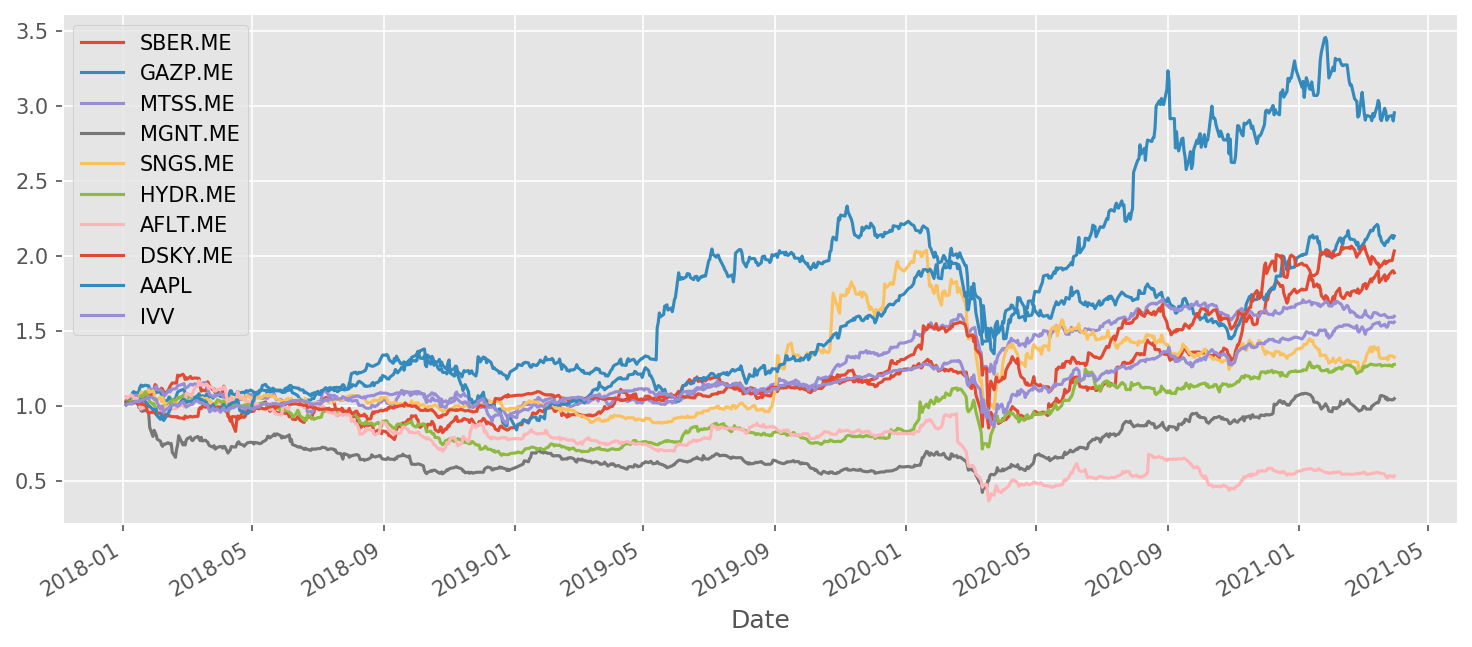

In [7]:
portfolio1.graphics()

In [8]:
portfolio1.resample_to_months()
portfolio1.new_data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-31,176.207153,116.088120,222.070801,4187.981445,26.922180,0.625404,120.766647,66.784569,40.219990,266.416565
2018-02-28,181.470032,115.926170,221.064667,3757.396973,26.898762,0.673677,128.150345,65.340576,42.962379,256.281250
2018-03-31,168.925705,115.254066,211.398468,3677.251709,26.575584,0.663678,140.969910,69.636444,40.468391,249.931442
2018-04-30,151.218384,118.169220,213.015472,3851.685303,27.577906,0.642213,130.460587,67.434357,39.860565,250.816803


In [9]:
portfolio1.get_month_return()

SBER.ME    0.013227
GAZP.ME    0.017778
MTSS.ME    0.009287
MGNT.ME    0.006365
SNGS.ME    0.006591
HYDR.ME    0.006929
AFLT.ME   -0.015324
DSKY.ME    0.019948
AAPL       0.029234
IVV        0.010551
dtype: float64

In [10]:
portfolio1.get_month_COV()

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
SBER.ME,0.007539,0.003462,0.002182,0.002707,0.002670,0.002698,0.005791,0.004043,0.002570,0.002961
GAZP.ME,0.003462,0.006698,0.001478,0.001079,0.003083,0.000643,0.004573,0.001825,0.001366,0.001786
MTSS.ME,0.002182,0.001478,0.002039,0.001450,0.001521,0.001597,0.002418,0.001165,0.002504,0.001473
MGNT.ME,0.002707,0.001079,0.001450,0.006670,0.000873,0.002749,0.003082,0.001713,0.002311,0.001726
SNGS.ME,0.002670,0.003083,0.001521,0.000873,0.006255,0.000421,0.004285,0.001509,0.002645,0.002037
HYDR.ME,0.002698,0.000643,0.001597,0.002749,0.000421,0.004115,0.002654,0.002140,0.002137,0.001376
AFLT.ME,0.005791,0.004573,0.002418,0.003082,0.004285,0.002654,0.013436,0.004812,0.004742,0.004218
DSKY.ME,0.004043,0.001825,0.001165,0.001713,0.001509,0.002140,0.004812,0.005502,0.001754,0.001621
AAPL,0.002570,0.001366,0.002504,0.002311,0.002645,0.002137,0.004742,0.001754,0.009356,0.003495
IVV,0.002961,0.001786,0.001473,0.001726,0.002037,0.001376,0.004218,0.001621,0.003495,0.002828


In [11]:
portfolio1.get_month_risk(portfolio1.w)

0.002831285845151025

In [12]:
portfolio1.w

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

## Portfolio optimization

In [13]:
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
# names = ['AAPL', 'AMZN', 'IBM', 'SBER.ME']
dates = ('2018-01-01', '2021-02-01')
n = len(names)

portfolio_opt = OptimizationP(names, dates)
portfolio_opt.get_help()

maxReturn - maximize return of the portfolio
minRisk - minimize risk of the portfolio 
maxSharpe - maximize a Sharpe ratio
maxSortino - maximize a Sortino ratio 
minGenFun - minimize generalized function


In [14]:
portfolio_opt.get_ts_csv()
# portfolio_opt.get_ts()

In [15]:
portfolio_opt.resample_to_months()

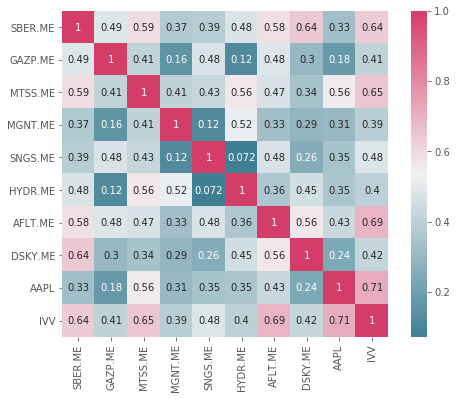

In [16]:
portfolio_opt.corr_matrix()

In [17]:
p_return = portfolio_opt.get_month_return()
p_cov = portfolio_opt.get_month_COV()

## Equally allocation

In [18]:
portfolio_opt.w

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [19]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.033 %
Risk: 0.297 %


## Maximize return

In [20]:
max_return = portfolio_opt.optimizeP('maxReturn', (0, 1), 0, rf)
max_return

     fun: -0.032962264957272086
     jac: array([-0.01064973, -0.01694936, -0.0109732 , -0.00443516, -0.00610109,
       -0.00615026,  0.01517284, -0.02107143, -0.03296226, -0.00914378])
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.00000000e+00, 7.41852379e-17, 5.66913050e-17, 1.28276694e-16,
       0.00000000e+00, 0.00000000e+00, 8.50474479e-17, 0.00000000e+00,
       1.00000000e+00, 3.30581100e-17])

In [21]:
max_return_ret = round(np.dot(p_return, max_return.x), 3)*100
max_return_risk = round(np.dot(max_return.x, np.dot(p_cov, max_return.x)), 3)*100

print(f'Return: {round(max_return_ret, 3)} %')
print(f'Risk: {round(max_return_risk, 3)} %')

Return: 3.3 %
Risk: 1.0 %


## Maximize Sharpe ratio

In [22]:
max_sharpe = portfolio_opt.optimizeP('maxSharpe', (0, 1), 0.01, rf)
max_sharpe

     fun: -6.157416022944237
     jac: array([11.29606324,  4.68234122,  4.67876995,  6.87836528,  7.44708103,
        6.58938843, 26.01048303,  4.68366146,  4.68397659,  6.79730189])
 message: 'Optimization terminated successfully.'
    nfev: 148
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([2.38046135e-13, 1.22602524e-01, 3.90682106e-01, 0.00000000e+00,
       6.87707621e-16, 0.00000000e+00, 8.33758510e-13, 2.75679898e-01,
       2.11035472e-01, 0.00000000e+00])

In [23]:
max_sharpe_ret = round(np.dot(p_return, max_sharpe.x)*100, 3)
max_sharpe_risk = round(np.dot(np.dot(max_sharpe.x, p_cov), max_sharpe.x)*100, 3)
max_sharpe_ratio = -max_sharpe.fun

print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')
print(f'Sharpe ratio: {round(max_sharpe_ratio, 3)}')

Return: 1.913 %
Risk: 0.251 %
Sharpe ratio: 6.157


## Maximize Sortino ratio

In [24]:
max_sortino = portfolio_opt.optimizeP('maxSortino', (0, 1), 0.01, rf)
max_sortino

     fun: 0.9871828494951285
     jac: array([-0.01087157, -0.01730244, -0.01120179, -0.00452756, -0.00622818,
       -0.00627839,  0.01548892, -0.02151038, -0.03364893, -0.00933427])
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.00000000e+00, 1.52748338e-16, 0.00000000e+00, 7.50615027e-17,
       0.00000000e+00, 3.28636301e-18, 0.00000000e+00, 2.08166817e-16,
       1.00000000e+00, 1.18854324e-16])

In [25]:
max_sort_ret = round(np.dot(p_return, max_sortino.x)*100, 3)
max_sort_risk = round(np.dot(np.dot(max_sortino.x, p_cov), max_sortino.x)*100, 3)

print(f'Return: {round(max_sort_ret, 3)} %')
print(f'Risk: {round(max_sort_risk, 3)} %')

Return: 3.296 %
Risk: 0.95 %


## Minimize risk

In [26]:
min_risk = portfolio_opt.optimizeP('minRisk', (0, 1), 0.01, rf)
min_risk

     fun: 0.0018726013617049561
     jac: array([0.00556893, 0.00354605, 0.0035492 , 0.00367349, 0.00379439,
       0.00411336, 0.00681522, 0.00369621, 0.0052891 , 0.00380729])
 message: 'Optimization terminated successfully.'
    nfev: 180
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([3.29140638e-17, 3.02082984e-02, 4.09223150e-01, 1.10831596e-02,
       8.38309195e-02, 1.97817507e-01, 6.64253362e-17, 5.90502234e-02,
       0.00000000e+00, 2.08786742e-01])

In [27]:
min_risk_ret = round(np.dot(p_return, min_risk.x)*100, 3)
min_risk_risk = round(np.dot(np.dot(min_risk.x, p_cov), min_risk.x)*100, 3)

print(f'Return: {round(min_risk_ret, 3)} %')
print(f'Risk: {min_risk_risk} %')

Return: 0.993 %
Risk: 0.187 %


## Minimize generalized function

In [28]:
gen_func = portfolio_opt.optimizeP('minGenFun', (0, 1), 0.01, rf, 0.35)
gen_func

     fun: -0.004953558393177102
     jac: array([ 3.25853843e-03, -1.17398991e-03, -8.54330719e-05,  2.56492267e-03,
        2.59638869e-03,  1.95455592e-03,  1.53668137e-02, -8.85367044e-04,
       -2.87062023e-04,  2.36419070e-03])
 message: 'Optimization terminated successfully.'
    nfev: 204
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([2.00227229e-17, 1.31016640e-01, 5.55111512e-17, 3.14787105e-17,
       1.98300261e-17, 0.00000000e+00, 0.00000000e+00, 3.64433828e-01,
       5.04549532e-01, 0.00000000e+00])

In [29]:
gen_func_ret = round(np.dot(p_return, gen_func.x)*100, 3)
gen_func_risk = round(np.dot(np.dot(gen_func.x, p_cov), gen_func.x)*100, 3)

print(f'Return: {gen_func_ret} %')
print(f'Risk: {gen_func_risk} %')

Return: 2.653 %
Risk: 0.433 %


## Minimize generalized function with free risk asset

In [30]:
genfunfree = portfolio_opt.optimizeP('minGenFunFree', (0, 1), 0, rf, 0.35)
genfunfree

     fun: -0.0049695487486102466
     jac: array([ 0.0024906 , -0.00161234, -0.00040416,  0.00217098,  0.00218771,
        0.00152498,  0.01435454, -0.00174541, -0.00109579,  0.00189247,
       -0.001295  ])
 message: 'Optimization terminated successfully.'
    nfev: 208
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([3.13823285e-18, 1.23496005e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.57372994e-17, 0.00000000e+00, 3.01647354e-01,
       4.74712489e-01, 3.53111512e-17, 1.00144152e-01])

In [31]:
genfunfree_ret = round(np.dot(p_return, genfunfree.x[:-1])*100 + 100*rf*genfunfree.x[-1], 3)
genfunfree_risk = round(np.dot(np.dot(genfunfree.x[:-1], p_cov), genfunfree.x[:-1])*100, 3)

print(f'Return: {genfunfree_ret} %')
print(f'Risk: {genfunfree_risk} %')

Return: 2.447 %
Risk: 0.359 %


## Multi-criteria optimization

In [32]:
mc = portfolio_opt.multi_criteria_opt((0, 1), 0.01, rf, 0.05)
mc

     fun: 0.9433772551680913
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
 message: 'Optimization terminated successfully.'
    nfev: 158
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([2.50590958e-16, 1.50666681e-01, 6.72065704e-17, 0.00000000e+00,
       5.76937724e-17, 8.47620492e-17, 5.84321896e-18, 3.65811905e-01,
       4.83521415e-01, 3.40599328e-17, 9.43377255e-01])

In [33]:
mc_ret = round(np.dot(p_return, mc.x[:-1])*100, 3)
mc_risk = round(np.dot(np.dot(mc.x[:-1], p_cov), mc.x[:-1])*100, 3)

print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 2.62 %
Risk: 0.42 %


## Efficient frontier

In [34]:
h0, h1, a0, a1, b0 = portfolio_opt.optimal_t()
a0 = a0*100
a1 = a1*100
b0 = b0*100
# optimal t
t0 = (max_return_ret - a0)/a1
t0

0.054592538364343766

In [35]:
eff_frontier = portfolio_opt.efficient_frontier((0, 1), 0.01)
not_eff_reg = portfolio_opt.not_efficient_region((0, 1), 0.01)

In [36]:
num_portf = 1000
p_r = []
p_std = []
p_w = []
sharpe_ratio = []

for i in range(num_portf):
    w = np.random.uniform(0, 1, n)
    w = w/np.sum(w)
#     w = np.random.dirichlet(np.ones(n)*100,size=1)[0]
    p_w.append(w)
    
    returns = np.dot(w, p_return)
    p_r.append(round(100*returns, 3))
    
    std = np.dot(np.dot(w, p_cov), w)
    p_std.append(round(100*std, 3))
    
    sharpe_ratio.append((returns - rf)/std)

In [37]:
array = {'Returns':p_r, 'Risks':p_std}

for i, stock in enumerate(names):
    array[stock] = [w[i] for w in p_w]
    
portfolios = pd.DataFrame(array)    
portfolios.head(5)

,Returns,Risks,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
0,0.620,0.343,0.106548,0.012414,0.156156,0.174242,0.046004,0.076515,0.190713,0.091570,0.052298,0.093539
1,0.865,0.329,0.088297,0.071418,0.012655,0.210019,0.075673,0.091818,0.131049,0.130587,0.080220,0.108263
2,1.508,0.294,0.155252,0.118770,0.091373,0.076018,0.044726,0.067208,0.021568,0.197465,0.145896,0.081724
3,0.632,0.336,0.018079,0.149901,0.054267,0.059626,0.121196,0.187912,0.199119,0.123597,0.019438,0.066864
4,0.925,0.307,0.180153,0.089329,0.105730,0.016591,0.142673,0.081983,0.084075,0.106995,0.019754,0.172715


In [38]:
((portfolios['Returns']-rf)/portfolios['Risks']).max()

6.035227272727272

In [39]:
sharpe = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Risks']).argmax()]
sharpe

Returns    1.597000
Risks      0.264000
SBER.ME    0.011460
GAZP.ME    0.153709
MTSS.ME    0.007595
MGNT.ME    0.103552
SNGS.ME    0.041233
HYDR.ME    0.115268
AFLT.ME    0.001256
DSKY.ME    0.202941
AAPL       0.174934
IVV        0.188052
Name: 483, dtype: float64

In [40]:
def CML(x, r, var):
    return rf + x*(r-rf)/var

def f(x):
    return np.sqrt(a1*(x - b0)) + a0

x = np.linspace(min_risk_risk/2, (max_return_risk)/2+0.2, 50)

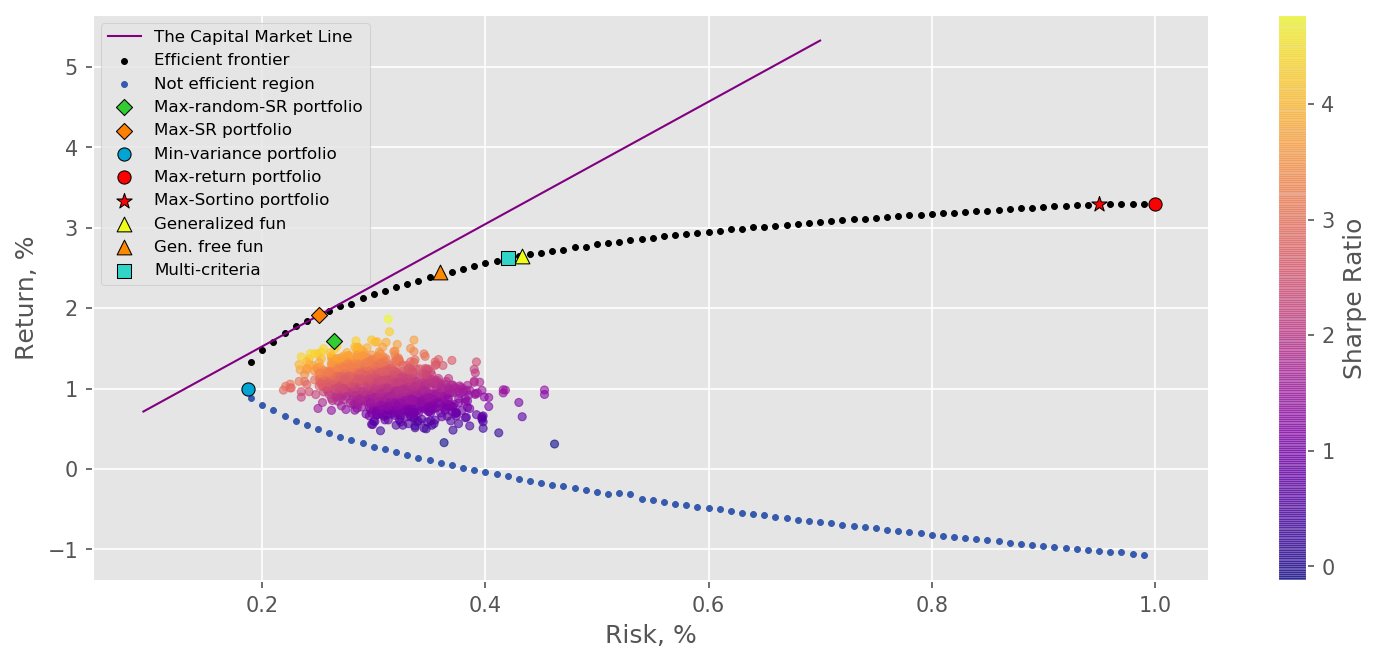

In [41]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

plt.scatter(eff_frontier[0], eff_frontier[1], c='black', zorder=2, s=8, label='Efficient frontier')
plt.scatter(not_eff_reg[0], not_eff_reg[1], c='#365aad', zorder=2, s=8, label='Not efficient region')

plt.scatter(portfolios['Risks'], portfolios['Returns'], s=15, alpha=0.6, c=sharpe_ratio, cmap='plasma')
plt.colorbar(label = 'Sharpe Ratio')

plt.plot(x, CML(x, max_sharpe_ret, max_sharpe_risk), linewidth=1, c='purple', \
           label='The Capital Market Line', zorder=2) #the CML

plt.scatter(sharpe['Risks'], sharpe['Returns'], s=30, c='#32CD32', marker='D', \
            edgecolor='black', label='Max-random-SR portfolio', zorder=3)#Random best sharpe ratio (0, 1)

plt.scatter(max_sharpe_risk, max_sharpe_ret, s=30, c='#ff8000', edgecolor='black', \
           label='Max-SR portfolio', marker='D', zorder=3) #sharpe ratio (0, 1)

plt.scatter(min_risk_risk, min_risk_ret, s=40, c='#02a4d3', edgecolor='black', \
           label='Min-variance portfolio', zorder=3) #min risk (0, 1)

plt.scatter(max_return_risk, max_return_ret, s=40, c='r', edgecolor='black', \
           label='Max-return portfolio', zorder=3) #max return (0, 1)

plt.scatter(max_sort_risk, max_sort_ret, s=60, c='r', edgecolor='black', \
           label='Max-Sortino portfolio', marker='*', zorder=3) #max Sortino ratio (0, 1)

plt.scatter(gen_func_risk, gen_func_ret, s=50, c='#effd17', edgecolor='black', \
           label='Generalized fun', marker='^', zorder=3) #gen func

plt.scatter(genfunfree_risk, genfunfree_ret, s=50, c='#fa8800', edgecolor='black', \
           label='Gen. free fun', marker='^', zorder=3) #gen func free

plt.scatter(mc_risk, mc_ret, s=40, c='#30d5c8', edgecolor='black', \
           label='Multi-criteria', marker='s', zorder=3) #multi-criteria

plt.xlabel('Risk, %')
plt.ylabel('Return, %')
# plt.xlim(min_risk_risk-0.02, max_return_risk+0.02)
# plt.ylim(-1, 10)
plt.legend(loc=2, prop={'size': 8})
plt.show()

## Indicators

In [42]:
#download market portfolio
market_portfolio = yf.download('SPY', dates[0], dates[1])['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [43]:
mp_pct_change = market_portfolio.resample('M').last().pct_change(1).apply(lambda x: np.log(1+x))
mp_mean = mp_pct_change.mean()
mp_var = mp_pct_change.var()
print(f'Market portfolio mean: {round(mp_mean*100, 3)} %\nMarket portfolio variance: {round(mp_var*100, 3)} %')

Market portfolio mean: 0.912 %
Market portfolio variance: 0.288 %


In [44]:
all_ind_ret = np.array([max_return_ret, max_sharpe_ret, max_sort_ret, min_risk_ret,\
                        gen_func_ret, genfunfree_ret, mc_ret])
all_ind_risk = np.array([max_return_risk, max_sharpe_risk, max_sort_risk, min_risk_risk,\
                         gen_func_risk, genfunfree_risk, mc_risk])
all_w = np.array([max_return.x, max_sharpe.x, max_sortino.x, min_risk.x, gen_func.x, genfunfree.x[:n], mc.x[:n]])

In [45]:
pct_change = portfolio_opt.get_pct_change()
month_return = portfolio_opt.get_month_return()
beta_ind = []
n = len(names)

for i in range(n):
    beta_ind.append(((mp_pct_change.values[1:] * pct_change.iloc[1:, i].values).mean()-mp_mean*month_return[i])/mp_var)
    
all_beta = []

for i in range(len(all_w)):
    all_beta.append(np.dot(np.array(beta_ind), all_w[i]))

In [46]:
indicators = np.array([list(map(lambda x: str(round(x, 3))+'%', all_ind_ret)),\
                       list(map(lambda x: str(round(x, 3))+'%', all_ind_risk)),\
                       np.around(np.array(all_ind_ret/all_ind_risk), 3), np.around(all_beta, 3),\
                       np.around((all_ind_ret-rf)/all_beta, 3)])
columns = ['Max return', 'Max Sharpe ratio', 'Max Sortino ratio', 'Min risk', 'Generalized fun',\
           'Generalized free fun', 'Multi-criteria']
index = ['Return', 'Risk', 'Return/Risk', 'Beta', 'Treynor ratio']

indicators_df = pd.DataFrame(indicators, columns=columns, index=index)
indicators_df

,Max return,Max Sharpe ratio,Max Sortino ratio,Min risk,Generalized fun,Generalized free fun,Multi-criteria
Return,3.3%,1.913%,3.296%,0.993%,2.653%,2.447%,2.62%
Risk,1.0%,0.251%,0.95%,0.187%,0.433%,0.359%,0.42%
Return/Risk,3.3,7.622,3.469,5.31,6.127,6.816,6.238
Beta,1.263,0.714,1.263,0.636,0.936,0.856,0.922
Treynor ratio,2.61,2.672,2.606,1.556,2.831,2.854,2.836


# Modeling

In [47]:
#download currency information
curr = yf.download('RUB=X', dates[1], datetime.date.today())['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [64]:
budget = 1000000
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
# names = ['SBER.ME', 'AAPL', 'AMZN', 'IBM']

dates = ('2018-01-01', '2021-02-01')
m = 1 #stocks in currency 1
# m = 1
t = 0.1

In [65]:
class Model:
    def __init__(self, type_opt, names, dates, m, rf, t, curr, budget, rb=False):
        self.type_opt = type_opt
        self.portfolio = OptimizationP(names, dates)
        self.rf = rf
        self.t = t
        self.costs = []
        self.res = []
        self.m = m
        self.curr = curr
        self.budget = budget
        self.forecast_data = []
        self.names = names
        self.portfolio.get_ts()
#         self.portfolio.get_ts_csv()
        self.portfolio.resample_to_months()
        self.income = []
        self.rb = rb
        self.cov_matrix = 0
        self.r = 0
        self.risk = 0.01
        self.fee_array = []
        self.fee = 0.03
        self.tax = 0.13
        
    def opt(self):
        if self.type_opt == 'multi-criteria':
            self.portfolio.multi_criteria_opt((0, 1), 0.01, self.rf, self.t)
        else:
            self.portfolio.optimizeP(self.type_opt, (0, 1), 0.01, self.rf)
            
        self.cov_matrix = self.portfolio.get_month_COV()
        self.risk = np.dot(self.portfolio.w[:self.portfolio.n], \
                           np.dot(self.cov_matrix, self.portfolio.w[:self.portfolio.n]))
        self.r = np.dot(self.portfolio.w[:self.portfolio.n], self.portfolio.get_month_return())
        
    def buy(self): #get quantity of assets at moment t0
        self.opt()
        self.costs = []
        self.res = []
        self.costs = np.array(self.portfolio.data.iloc[-1])

        u = np.dot(self.portfolio.w, self.budget)

        for i in range(self.m):
            self.res.append(u[i] / self.costs[i])
            self.fee_array.append((self.fee*self.costs[i])*(u[i] / self.costs[i]))

        for i in range(self.m, self.portfolio.n):
            self.res.append(u[i] / (self.curr[-1]*self.costs[i])) 

        return self.res
    
    def quant(self):
        temp = self.buy()
        return f'Quantity {self.type_opt}: {[round(i) for i in temp]}'
    
    def forecast(self):
        self.forecast_data = []
        for name in self.names:
            data_prophet = self.portfolio.new_data[[name]]
            data_prophet = data_prophet.reset_index()
            data_prophet.columns = ['ds', 'y']
            model = Prophet(weekly_seasonality=False, daily_seasonality=False)
            model.fit(data_prophet)
            future = model.make_future_dataframe(periods=5, freq='MS')
            forecast = model.predict(future)['yhat'].values[-5:]
#             model = ARIMA(self.portfolio.new_data[name], order=(1,2,1), freq='M')
#             model_fit = model.fit()
#             forecast = model_fit.forecast(5)
            print(forecast)
            self.forecast_data.append(np.array(forecast))

        self.forecast_data = np.array(self.forecast_data)
        return self.forecast_data
    
    def plot_forecast(self):
        start = self.portfolio.new_data.index[-1] + pd.DateOffset(months=1)
        end = start + pd.DateOffset(months=5)
        self.fdf = pd.DataFrame(index = pd.date_range(start, end, freq='MS'), columns=self.names)
        
        for i, name in enumerate(self.names):
            self.fdf[name] = pd.DataFrame(self.forecast_data[i])
            
        fig, ax = plt.subplots(figsize=(12, 5))
        (self.portfolio.new_data.pct_change(1)+1).cumprod().plot(ax=ax)
        (self.fdf.pct_change(1)+1).cumprod().plot(ax=ax)
        plt.show()
        
        
    def portfolio_return(self):
        self.forecast()
        if self.rb:
            total_income = self.budget
            b = self.budget
            self.rb_data = self.portfolio.data
            for j in range(len(self.forecast_data[0])):
                self.portfolio.data.loc[f'pr{j}'] = self.forecast_data.T[j]
                self.budget = total_income
                self.income = []
                s = self.buy()
                for i in range(self.m):
                    self.income.append(self.forecast_data[i, j]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))

                for i in range(self.m, self.portfolio.n):
                    self.income.append(self.forecast_data[i, j]*self.curr[-1]*s[i] +\
                                       s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))
                total_income = sum(self.income)
            return total_income - b
        
        elif not self.rb:    
            self.income = []
            s = self.buy()

            for i in range(self.m):
                self.income.append(self.forecast_data[i, -1]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))
                self.fee_array[i] = self.fee_array[i] + (self.fee*self.forecast_data[i, -1]*s[i])

            for i in range(self.m, self.portfolio.n):
                self.income.append(self.forecast_data[i, -1]*self.curr[-1]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))
                                  
            return sum(self.income) - self.budget - sum(self.fee_array) - (sum(self.income) - self.budget)*self.tax
        
        else:
            print('Specify True or False rebalance!')

In [66]:
# names_opt = ('maxReturn', 'minRisk', 'maxSharpe', 'maxSortino', 'minGenFun', 'minGenFunFree', 'multi-criteria')
names_opt = ['maxReturn']
total_return = []
quantities = []
rb = False

for name in names_opt:
    model = Model(name, names, dates, m, rf, t, curr, budget, rb)
    total_return.append(model.portfolio_return())
    quantities.append(model.quant())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[279.27002718 199.90566472 163.09909088 192.91944766 232.45573025]
[206.68565456 234.15806554 191.05296877 202.75560878 202.63276408]
[310.89691498 396.62378563 340.36624868 356.28649143 343.93032736]
[5041.23042096 4176.12020659 4597.66013359 5442.47889579 5324.4761888 ]
[29.35254635 53.88572908 36.2008513  

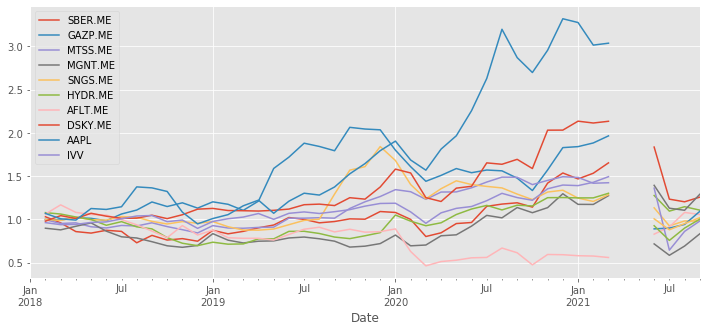

In [81]:
start = portfolio1.new_data.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=5)
fdf = pd.DataFrame(index = pd.date_range(start, end, freq='MS'))
        
for i, name in list(enumerate(names)):
    fdf[name] = model.forecast_data[i]
            
fig, ax = plt.subplots(figsize=(12, 5))
(portfolio1.new_data.pct_change(1)+1).cumprod().plot(ax=ax)
(fdf.pct_change(1)+1).cumprod().plot(ax=ax, legend=None)
plt.show()

In [82]:
fdf

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
2021-05-01,279.270027,206.685655,310.896915,5041.230421,29.352546,0.717391,54.095220,123.956691,136.743900,386.735595
2021-06-01,199.905665,234.158066,396.623786,4176.120207,53.885729,0.638273,73.599534,172.698855,137.581682,358.135225
2021-07-01,163.099091,191.052969,340.366249,4597.660134,36.200851,0.644500,34.821202,139.910501,120.186769,292.408523
2021-08-01,192.919448,202.755609,356.286491,5442.478896,35.300372,0.675049,46.546800,136.926012,129.963800,347.502158
2021-09-01,232.455730,202.632764,343.930327,5324.476189,36.885033,0.783571,53.035931,159.846084,139.387690,387.660829


In [151]:
for i, name in enumerate(names_opt):
    print(f'{name}: {round(total_return[i], 3)}')

maxReturn: 50646.075


In [150]:
quantities

['Quantity maxReturn: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.0, 0.0]',
 'Quantity minRisk: [0.0, 136.0, 1192.0, 2.0, 2625.0, 239417.0, 0.0, 375.0, 0.0, 7.0]',
 'Quantity maxSharpe: [0.0, 603.0, 1243.0, 0.0, 0.0, 0.0, 0.0, 1913.0, 22.0, 0.0]',
 'Quantity maxSortino: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 0.0]',
 'Quantity minGenFun: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 987.0, 81.0, 0.0]',
 'Quantity minGenFunFree: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1004.0, 82.0, 0.0]',
 'Quantity multi-criteria: [0.0, 699.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2405.0, 47.0, 0.0]']

MIT License

Copyright (c) 2021 Kirill Zakharov

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.